In [1]:
# Install YOLOv8 and necessary dependencies
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.5/913.5 kB 22.1 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='8a1b95ea42f6c41ac024eae0d344b48f4b62a3f4')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Define paths
root_dir = '/kaggle/input/toothdecaydetection'
v1_dir = os.path.join(root_dir, '/kaggle/input/toothdecaydetection')
v2_dir = os.path.join(root_dir, '/kaggle/input/dentistryindianpaper/dentistry_dataset')

In [5]:
# Ensure the YOLOv8 data directories exist
os.makedirs('yolov11/data/caries_v1', exist_ok=True)
os.makedirs('yolov11/data/caries_v2', exist_ok=True)

Displaying some training images from version 1:


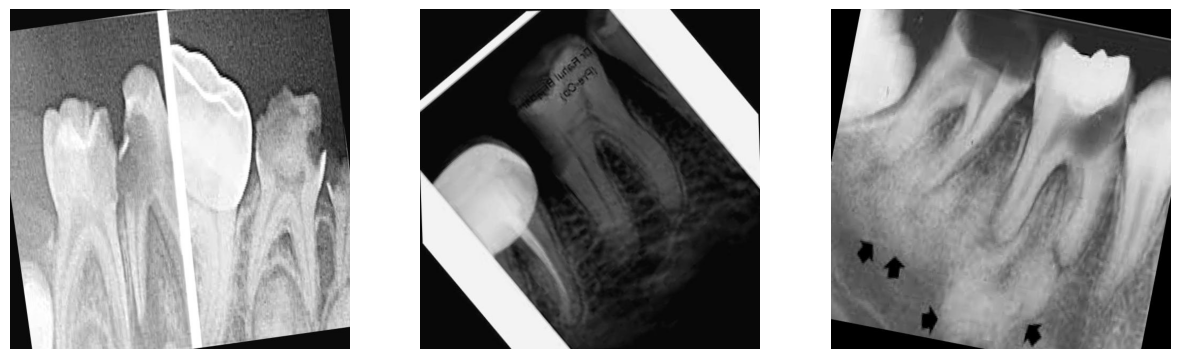

Displaying some training images from version 2:


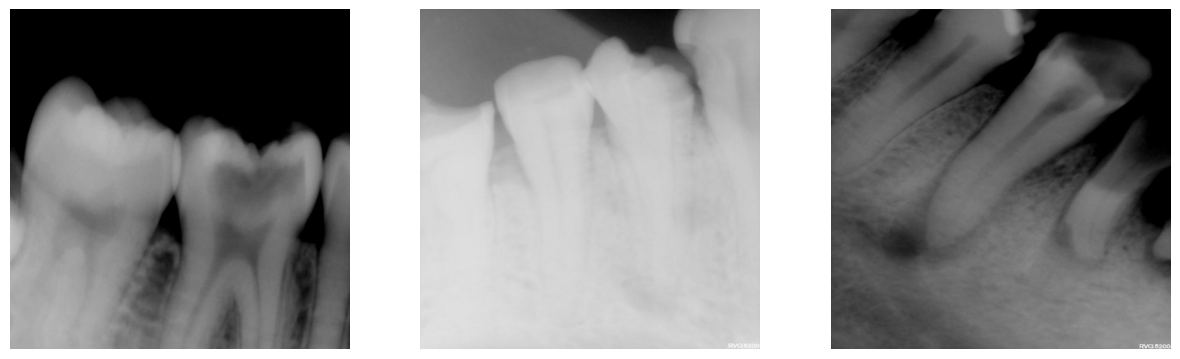

In [6]:
# Function to display images
def display_images(image_dir, num_images=3):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

# Display some training images
print("Displaying some training images from version 2:")
display_images(os.path.join(v2_dir, 'train/images'))


In [7]:
# Copy dataset to YOLOv8 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, 'yolov11/data/caries_v1')

# Copy version 2 dataset
copy_dataset_to_yolo(v2_dir, 'yolov11/data/caries_v2')

In [8]:
# Update data.yaml paths
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1
update_data_yaml('yolov11/data/caries_v1/data.yaml', '/kaggle/working/yolov11/data/caries_v1')

# Update data.yaml for version 2
update_data_yaml('yolov11/data/caries_v2/data.yaml', '/kaggle/working/yolov11/data/caries_v2')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('yolov11/data/caries_v1/data.yaml')

#print("Updated data.yaml for version 2:")
print_data_yaml('yolov11/data/caries_v2/data.yaml')

Updated data.yaml for version 1:
train: /kaggle/working/yolov11/data/caries_v1/train/images
val: /kaggle/working/yolov11/data/caries_v1/valid/images
test: /kaggle/working/yolov11/data/caries_v1/test/images

nc: 2
names: ['Dentin_Caries', 'Pulpitis_Caries']

roboflow:
  workspace: cocoyaml
  project: tooth-decay-dectection-6hjk3-lvwpt
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/cocoyaml/tooth-decay-dectection-6hjk3-lvwpt/dataset/1
train: /content/drive/MyDrive/dheeraj dentistry.yolov7pytorch/train
val: /content/drive/MyDrive/dheeraj dentistry.yolov7pytorch/valid
test: /content/drive/MyDrive/dheeraj dentistry.yolov7pytorch/test

nc: 4
names: ['carries', 'deep carries', 'exclusion', 'exclusion1']

roboflow:
  workspace: cropweed-ip5ij
  project: dheeraj-dentistry
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/cropweed-ip5ij/dheeraj-dentistry/dataset/1


In [9]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))
v2_train_labels = load_labels(os.path.join(v2_dir, 'train/labels'))

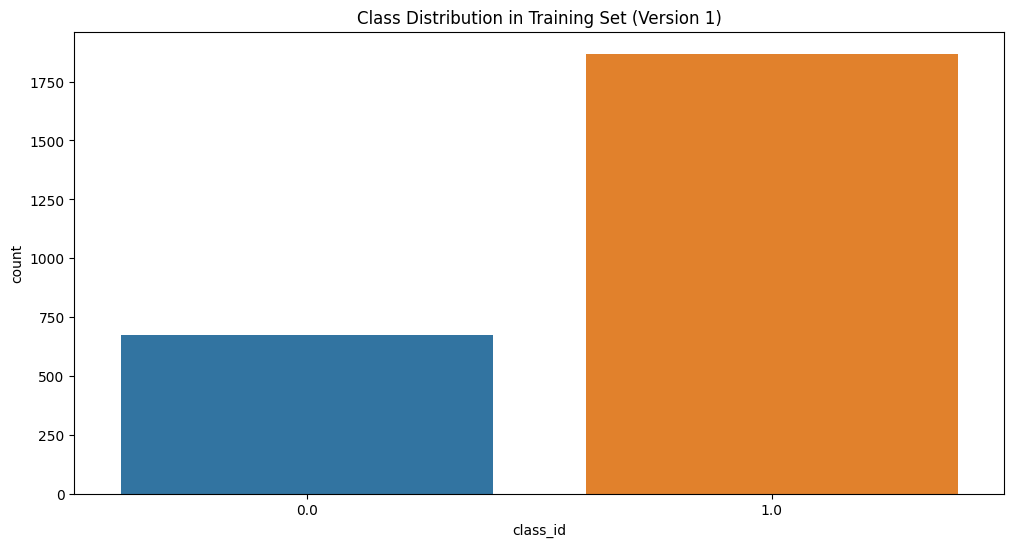

In [10]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

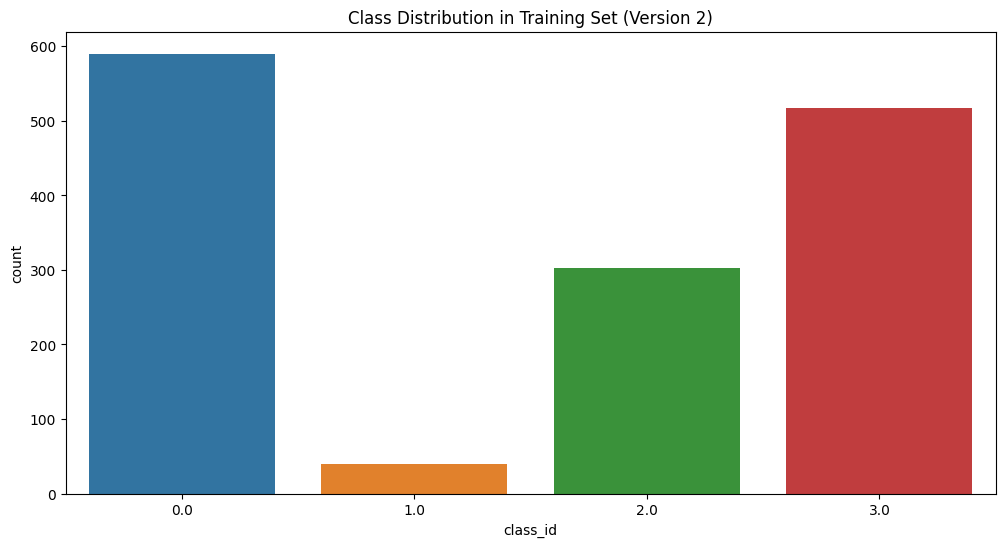

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=v2_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 2)')
plt.show()

In [12]:
from ultralytics import YOLO
# Train YOLOv11 model with augmentation and hyperparameter tuning
# Initialize model
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 112MB/s]


In [13]:
from ultralytics import YOLO
# Train YOLOv11 model with augmentation and hyperparameter tuning
# Initialize model
model1 = YOLO("yolo11n.pt")

In [14]:
# Train model on version 1 dataset
model.train(data='/kaggle/input/toothdecaydetection/data.yaml', 
            epochs=100, 
            imgsz=640, 
            batch=16, 
            name='caries_v1_aug', 
            lr0=0.01, 
            momentum=0.937, 
            weight_decay=0.0005, 
            warmup_epochs=3.0, 
            warmup_momentum=0.8, 
            warmup_bias_lr=0.1,
            box=0.05, 
            cls=0.5, 
            iou=0.2, 
            hsv_h=0.015, 
            hsv_s=0.7, 
            hsv_v=0.4, 
            translate=0.1, 
            scale=0.5, 
            mosaic=1.0, 
            mixup=0.5,
           plots=True)

Ultralytics 8.3.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/toothdecaydetection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=caries_v1_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]
2025-01-26 09:11:00,527	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-26 09:11:01,247	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/toothdecaydetection/train/labels... 1764 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1764/1764 [00:01<00:00, 1064.99it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/toothdecaydetection/train is not writeable, cache not saved.


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/toothdecaydetection/valid/labels... 169 images, 7 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<00:00, 504.39it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/toothdecaydetection/valid is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Plotting labels to runs/detect/caries_v1_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/caries_v1_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.71G    0.01527      3.451      2.118         14        640: 100%|██████████| 111/111 [00:27<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        169        266      0.427      0.178      0.317      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.7G    0.01387      2.715      1.996         21        640: 100%|██████████| 111/111 [00:24<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]

                   all        169        266      0.367       0.26      0.266     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.71G    0.01372      2.492      1.968         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]

                   all        169        266      0.496      0.281      0.275     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.69G    0.01367      2.368      2.001          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]

                   all        169        266      0.572      0.557      0.559       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.67G    0.01348      2.274      1.976         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266       0.54      0.592      0.561      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.68G    0.01333      2.213      1.979         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.697      0.581      0.609      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.65G    0.01307      2.126      1.927         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]

                   all        169        266      0.511      0.466      0.461      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.69G    0.01297      2.089      1.932         19        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]

                   all        169        266      0.585       0.52      0.526      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.68G     0.0129      2.029      1.919         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.589      0.617      0.621      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.69G    0.01296       2.02      1.899          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.732      0.679      0.693      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.68G    0.01283      1.975      1.908         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.628      0.642      0.647      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.68G    0.01265      1.928      1.893         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]

                   all        169        266      0.741      0.645      0.668      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.66G    0.01278      1.903       1.89         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]

                   all        169        266      0.637      0.552      0.551      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.71G    0.01286      1.956      1.899         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.702      0.635      0.629      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.66G     0.0125      1.861      1.884         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]

                   all        169        266      0.795      0.665      0.706      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.72G    0.01233      1.783      1.846         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.757      0.672      0.672      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.64G    0.01268      1.865      1.894         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]

                   all        169        266      0.771      0.658      0.703      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.71G    0.01253      1.833      1.863         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        169        266      0.703      0.601      0.644      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.65G    0.01241      1.785      1.855         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        169        266      0.718      0.675      0.672      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.71G    0.01236      1.806      1.855         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.756      0.704      0.695      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.67G    0.01233      1.813      1.865         23        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.738      0.659      0.664      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.71G    0.01238      1.794       1.86         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]

                   all        169        266      0.787      0.695      0.728      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.67G    0.01221      1.744       1.84         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266      0.752      0.694      0.701      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.71G    0.01227      1.741      1.848         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        169        266      0.583      0.576      0.542       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.67G    0.01227       1.72      1.828         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266      0.782      0.687       0.73      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.68G    0.01203        1.7      1.821          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]

                   all        169        266      0.744      0.636      0.716       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.68G    0.01209      1.672       1.81         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]

                   all        169        266       0.78      0.714       0.75      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.69G      0.012      1.614      1.799          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.863      0.709      0.785       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.66G    0.01199      1.641      1.818         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]

                   all        169        266       0.81      0.719       0.75      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.7G    0.01186      1.628       1.81         19        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]

                   all        169        266      0.764      0.725      0.742      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.66G    0.01188      1.648      1.795         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]

                   all        169        266      0.749      0.692      0.699      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.71G    0.01201      1.637      1.807         21        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]

                   all        169        266      0.812      0.758      0.763       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.67G    0.01187      1.608      1.791          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266      0.808      0.724      0.745      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.71G     0.0119       1.61      1.791         20        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.751       0.67      0.681       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.64G    0.01195      1.643      1.808         21        640: 100%|██████████| 111/111 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266       0.82      0.746      0.747      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.71G    0.01175       1.57      1.773         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266       0.81      0.739       0.75      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.66G    0.01189      1.586      1.799         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.818      0.708      0.737      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.71G    0.01167      1.561      1.766          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.784      0.766      0.762      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.66G    0.01181      1.552      1.791         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]

                   all        169        266      0.825      0.742      0.772      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.67G    0.01168      1.557      1.786         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]

                   all        169        266        0.8      0.732      0.738      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.65G    0.01177      1.587      1.781         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        169        266      0.806      0.759      0.775      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.67G    0.01177      1.543      1.775         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]

                   all        169        266       0.77      0.747      0.732      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.65G    0.01175      1.547      1.776          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

                   all        169        266      0.775      0.787      0.773      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.69G    0.01161      1.511      1.757         26        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]

                   all        169        266        0.8       0.75      0.772      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.71G    0.01165      1.521      1.758         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        169        266      0.769      0.745      0.761      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.68G    0.01158      1.511      1.752         21        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]

                   all        169        266      0.818      0.738      0.761      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.68G    0.01149      1.501      1.756         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all        169        266      0.817      0.739      0.767      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.72G    0.01163      1.535      1.771         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.773       0.77      0.764      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.66G    0.01141      1.479      1.739         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]

                   all        169        266       0.81      0.754      0.778      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.71G    0.01152      1.459      1.745          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.824      0.758      0.776      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.66G    0.01137      1.446      1.737         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        169        266      0.796      0.747      0.754      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.69G     0.0114      1.481      1.731          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]

                   all        169        266        0.8      0.795      0.803      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.66G    0.01148      1.438      1.745         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]

                   all        169        266      0.824      0.715       0.77      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.69G    0.01139      1.478      1.737         19        640: 100%|██████████| 111/111 [00:24<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]

                   all        169        266      0.745      0.778      0.743      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.67G    0.01128      1.438      1.729         18        640: 100%|██████████| 111/111 [00:24<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]

                   all        169        266      0.807       0.74      0.774      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.7G    0.01125      1.426      1.724         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]

                   all        169        266      0.802       0.77      0.779       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.66G    0.01131      1.414      1.731          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]

                   all        169        266      0.815      0.754      0.755      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.71G    0.01115      1.422      1.705         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266      0.816       0.78      0.796      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.68G    0.01118      1.428      1.704         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.805      0.777       0.77      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.69G    0.01128       1.41      1.716         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all        169        266      0.805      0.762      0.751      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.65G    0.01123      1.407      1.716         20        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.808      0.786      0.771      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.7G    0.01104      1.364      1.694         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        169        266      0.827      0.784      0.775      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.66G    0.01114      1.372        1.7         22        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all        169        266      0.808      0.808      0.786      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.72G    0.01106      1.372      1.711          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.793      0.754      0.737      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.69G    0.01107      1.372      1.696         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]

                   all        169        266      0.812       0.77      0.782      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.67G    0.01108      1.395        1.7         21        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]

                   all        169        266      0.792      0.783      0.759      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.65G    0.01106      1.373      1.697         19        640: 100%|██████████| 111/111 [00:23<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        169        266      0.802      0.786      0.761      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.69G    0.01094      1.353      1.686         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.76it/s]

                   all        169        266      0.788      0.778      0.744      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.65G    0.01088      1.341       1.67          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266      0.793      0.793      0.752      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.68G    0.01091      1.345      1.681         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]

                   all        169        266      0.797      0.797      0.777      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.66G    0.01084      1.349      1.676         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]

                   all        169        266      0.826      0.782      0.779      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.71G    0.01086      1.324      1.668          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]

                   all        169        266      0.839       0.78      0.797      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.7G    0.01089      1.318      1.672         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]

                   all        169        266      0.829      0.768      0.793      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.69G    0.01085      1.275      1.657         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]

                   all        169        266      0.807      0.791      0.785       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.66G    0.01076      1.294      1.662         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        169        266      0.815      0.774      0.771       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.72G    0.01084       1.31      1.662         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.789      0.769      0.758       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.66G    0.01067      1.271      1.649         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]

                   all        169        266       0.81      0.773      0.769      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.7G     0.0108      1.279      1.653         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.856      0.788        0.8      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.65G    0.01079      1.314      1.669         23        640: 100%|██████████| 111/111 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        169        266      0.788      0.761       0.76      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.72G    0.01072      1.292      1.652         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]

                   all        169        266      0.807      0.779      0.799      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.73G    0.01087       1.28       1.66         19        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all        169        266      0.777      0.764      0.748       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.71G    0.01081      1.298      1.663         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]

                   all        169        266      0.813      0.814      0.801      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.66G     0.0107      1.255      1.644         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

                   all        169        266      0.812      0.801      0.799      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.71G    0.01067      1.269      1.635         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]

                   all        169        266      0.811       0.79      0.798      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.69G    0.01061      1.246      1.639         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]

                   all        169        266        0.8      0.789      0.788      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.69G    0.01066      1.245      1.643          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        169        266      0.851      0.765      0.788      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.67G    0.01058      1.242      1.638         22        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266      0.844      0.774      0.786      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.69G    0.01055      1.249      1.638         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]

                   all        169        266      0.803      0.808       0.81      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.66G     0.0106      1.235      1.632         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]

                   all        169        266      0.849      0.782      0.797      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.69G    0.01054      1.234      1.635         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.852      0.761      0.787       0.39


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.64G    0.00935     0.8823      1.553          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.821      0.794      0.796      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.67G   0.009169     0.8208      1.535          5        640: 100%|██████████| 111/111 [00:22<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        169        266       0.84      0.768      0.793      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.68G   0.008997     0.8047       1.51         10        640: 100%|██████████| 111/111 [00:22<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]

                   all        169        266      0.843      0.758      0.768      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.67G   0.009004     0.7903      1.508          7        640: 100%|██████████| 111/111 [00:22<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]

                   all        169        266      0.851      0.774      0.801      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.64G   0.008892     0.7845      1.497          5        640: 100%|██████████| 111/111 [00:22<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.819      0.777      0.794      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.67G   0.008879     0.7619      1.501          4        640: 100%|██████████| 111/111 [00:22<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]

                   all        169        266      0.845       0.78      0.803      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.64G   0.008805     0.7606      1.491          4        640: 100%|██████████| 111/111 [00:22<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.846      0.786      0.805      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.67G   0.008705     0.7495      1.462          4        640: 100%|██████████| 111/111 [00:22<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]

                   all        169        266      0.829      0.771      0.794      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.64G   0.008788     0.7422      1.484          9        640: 100%|██████████| 111/111 [00:22<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.852      0.765      0.802      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.67G   0.008665     0.7569      1.472          4        640: 100%|██████████| 111/111 [00:22<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]

                   all        169        266      0.855       0.78      0.801      0.393



100 epochs completed in 0.704 hours.
Optimizer stripped from runs/detect/caries_v1_aug/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/caries_v1_aug/weights/best.pt, 5.5MB

Validating runs/detect/caries_v1_aug/weights/best.pt...
Ultralytics 8.3.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


                   all        169        266      0.803      0.807       0.81      0.405
         Dentin_Caries         54         85      0.737      0.692      0.715      0.314
       Pulpitis_Caries        141        181      0.869      0.923      0.906      0.496
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/caries_v1_aug
Ultralytics 8.3.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/dentistryindianpaper/dentistry_dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=caries_v2_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False,

RuntimeError: Dataset '/kaggle/input/dentistryindianpaper/dentistry_dataset/data.yaml' error ❌ 
Dataset '/kaggle/input/dentistryindianpaper/dentistry_dataset/data.yaml' images not found ⚠️, missing path '/content/drive/MyDrive/dheeraj dentistry.yolov7pytorch/valid'
Note dataset download directory is '/kaggle/working/datasets'. You can update this in '/root/.config/Ultralytics/settings.json'

In [ ]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model, os.path.join(v1_dir, 'test/images'))

#print("Displaying results from model trained on version 2 with augmentation:")
#display_results(model1, os.path.join(v2_dir, 'test/images'))


In [17]:
!ls /kaggle/working/runs/detect/caries_v1_aug/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


F1_curve.png					  train_batch1.jpg
PR_curve.png					  train_batch2.jpg
P_curve.png					  train_batch9990.jpg
R_curve.png					  train_batch9991.jpg
args.yaml					  train_batch9992.jpg
confusion_matrix.png				  val_batch0_labels.jpg
confusion_matrix_normalized.png			  val_batch0_pred.jpg
events.out.tfevents.1737882672.87c33ec67ade.34.0  val_batch1_labels.jpg
labels.jpg					  val_batch1_pred.jpg
labels_correlogram.jpg				  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


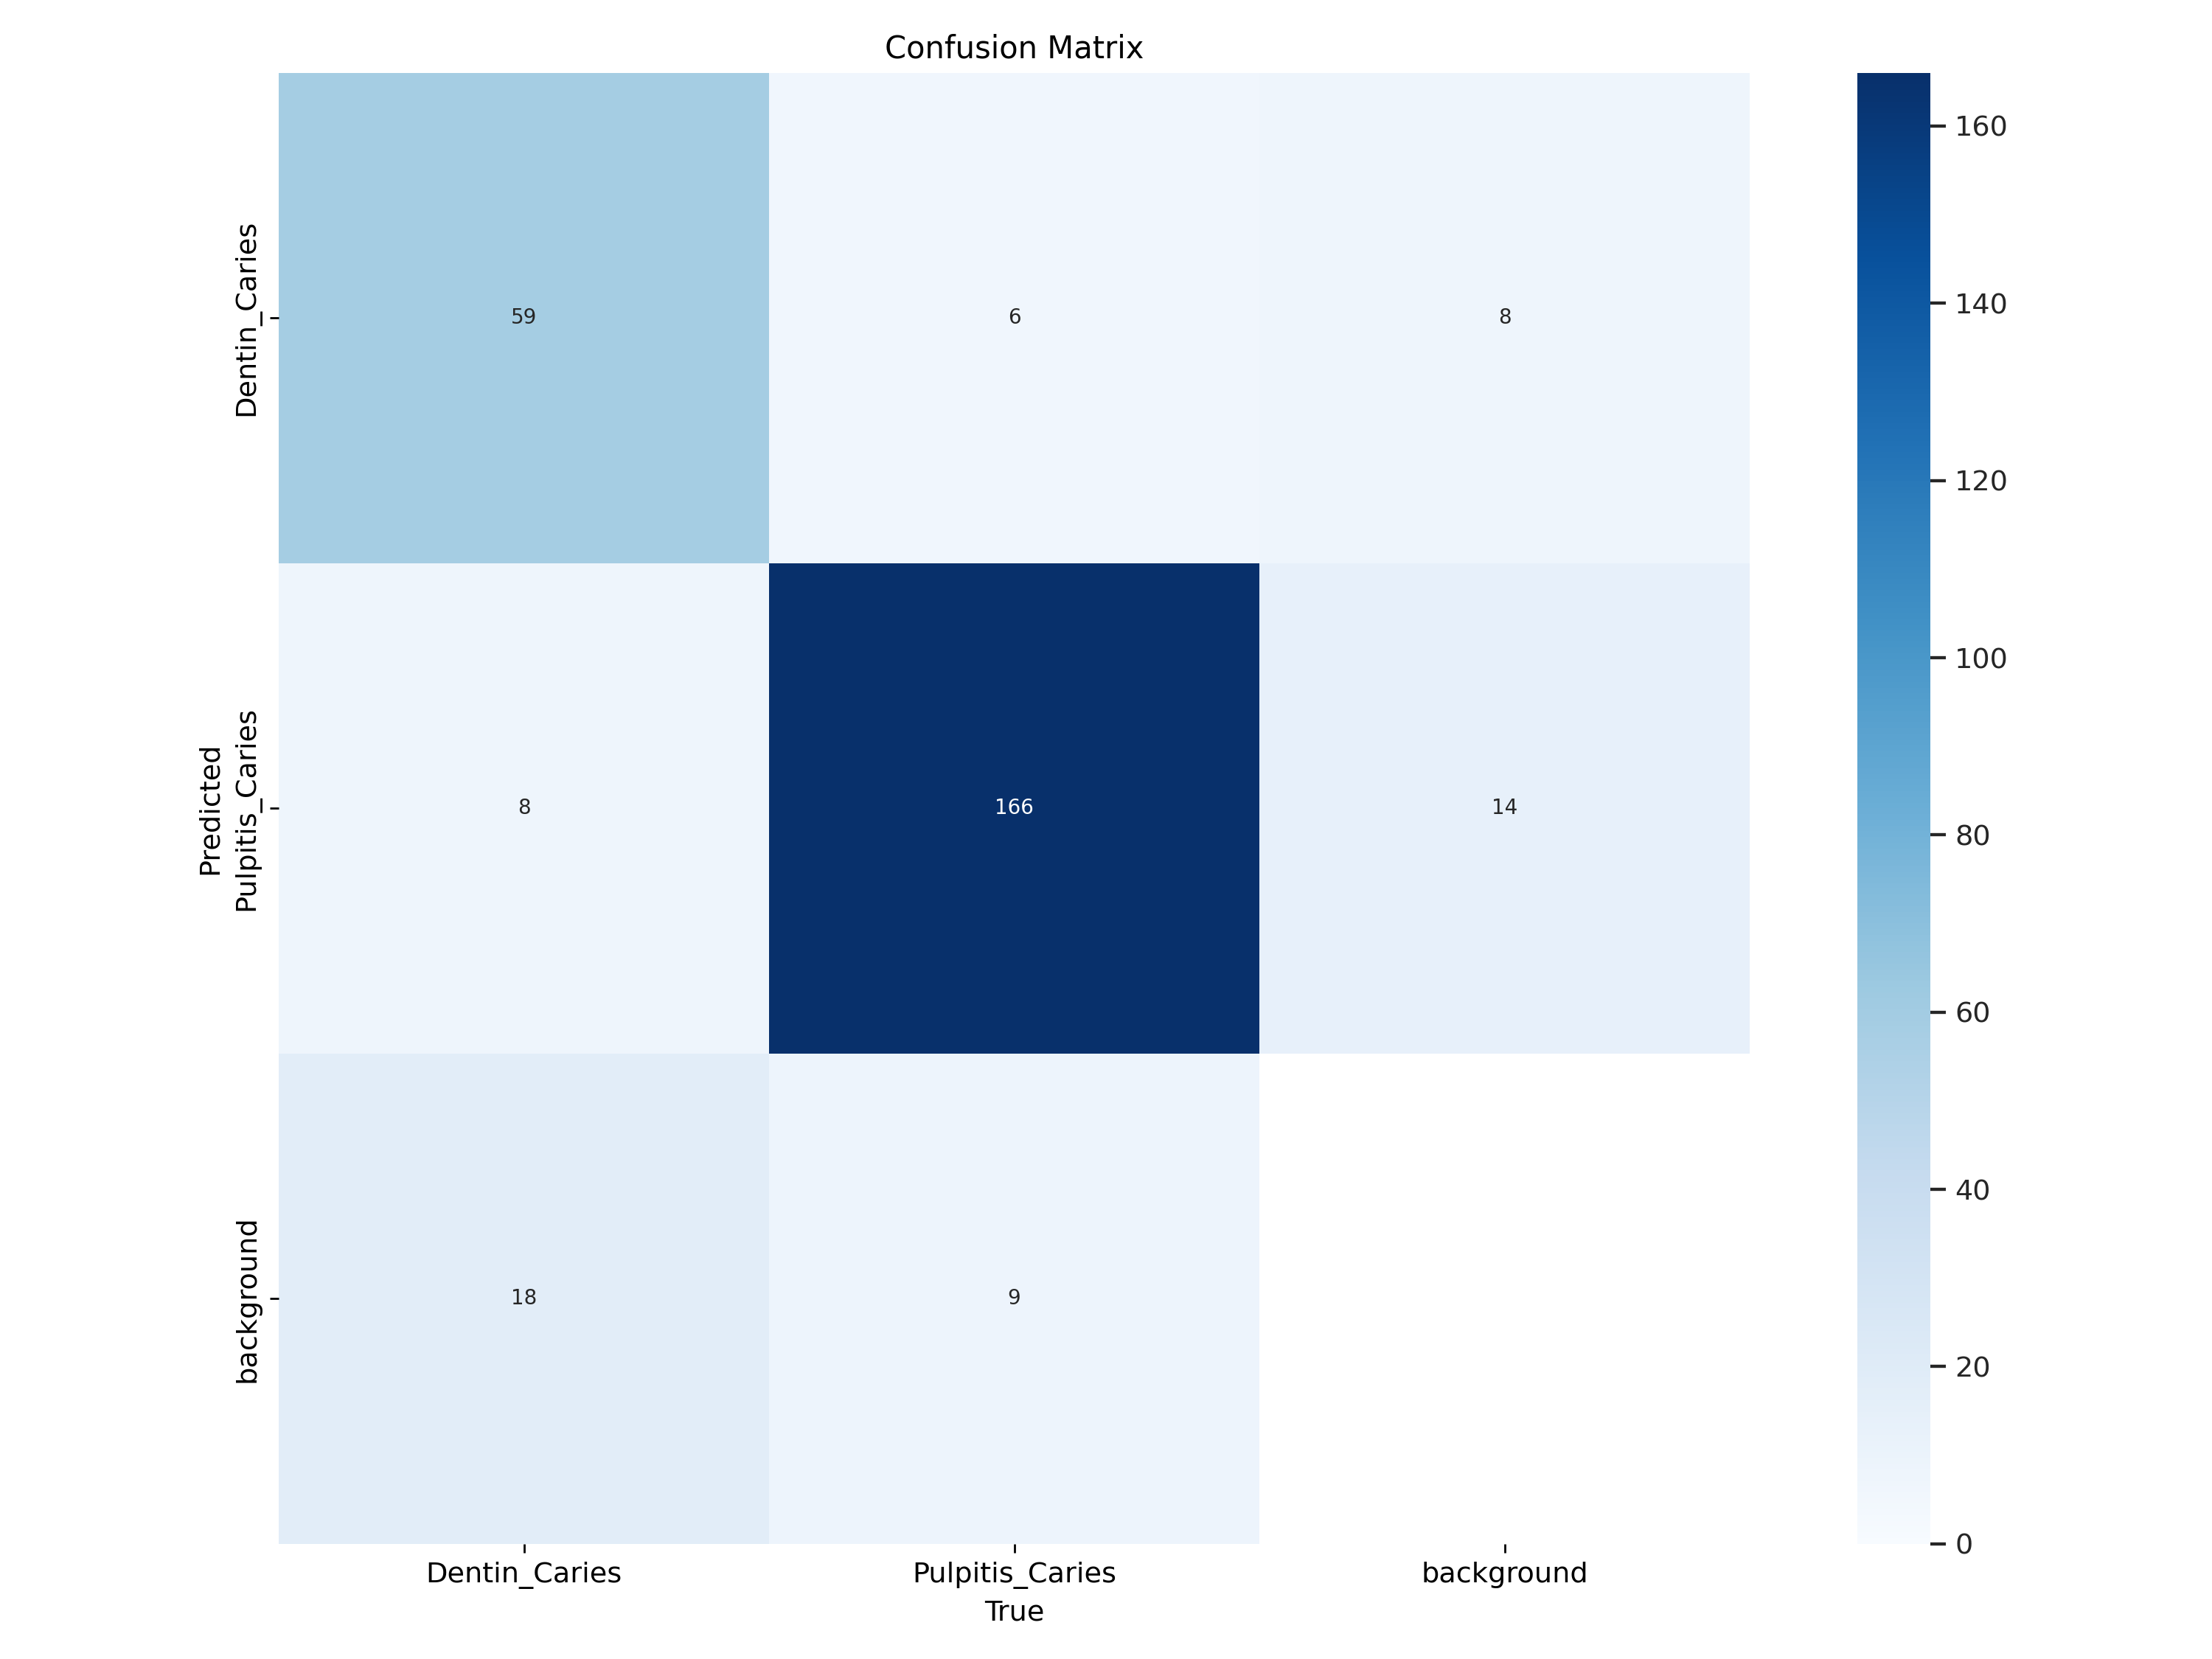

In [19]:
from IPython.display import Image as IPyImage

# Display the confusion matrix image from the specified directory in Kaggle
IPyImage(filename='/kaggle/working/runs/detect/caries_v1_aug/confusion_matrix.png', width=1000)


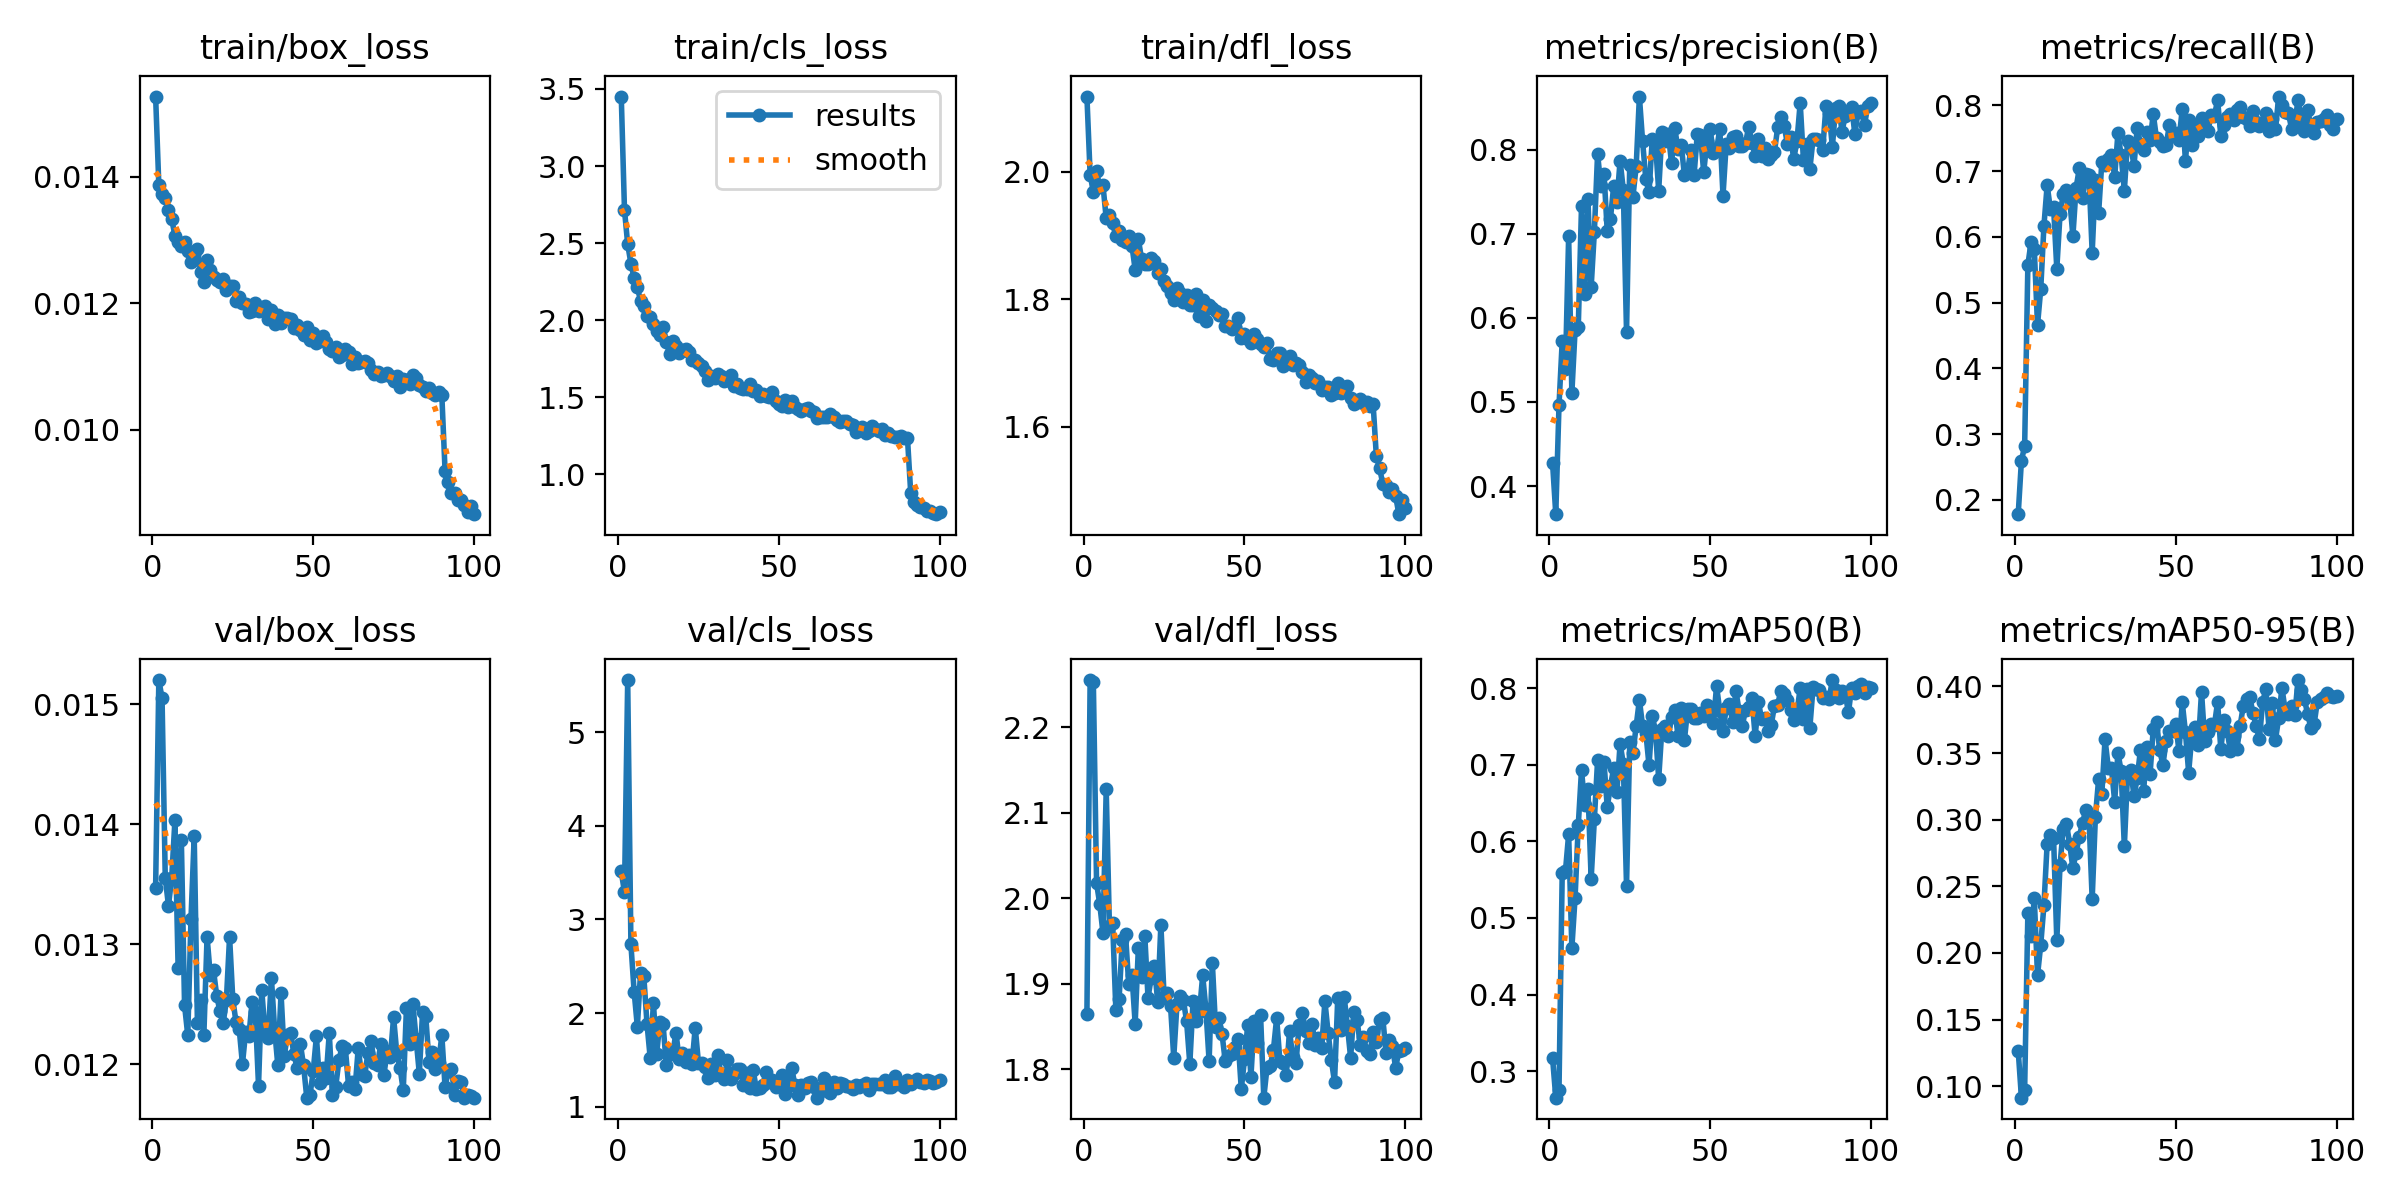

In [20]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/results.png', width=1000)

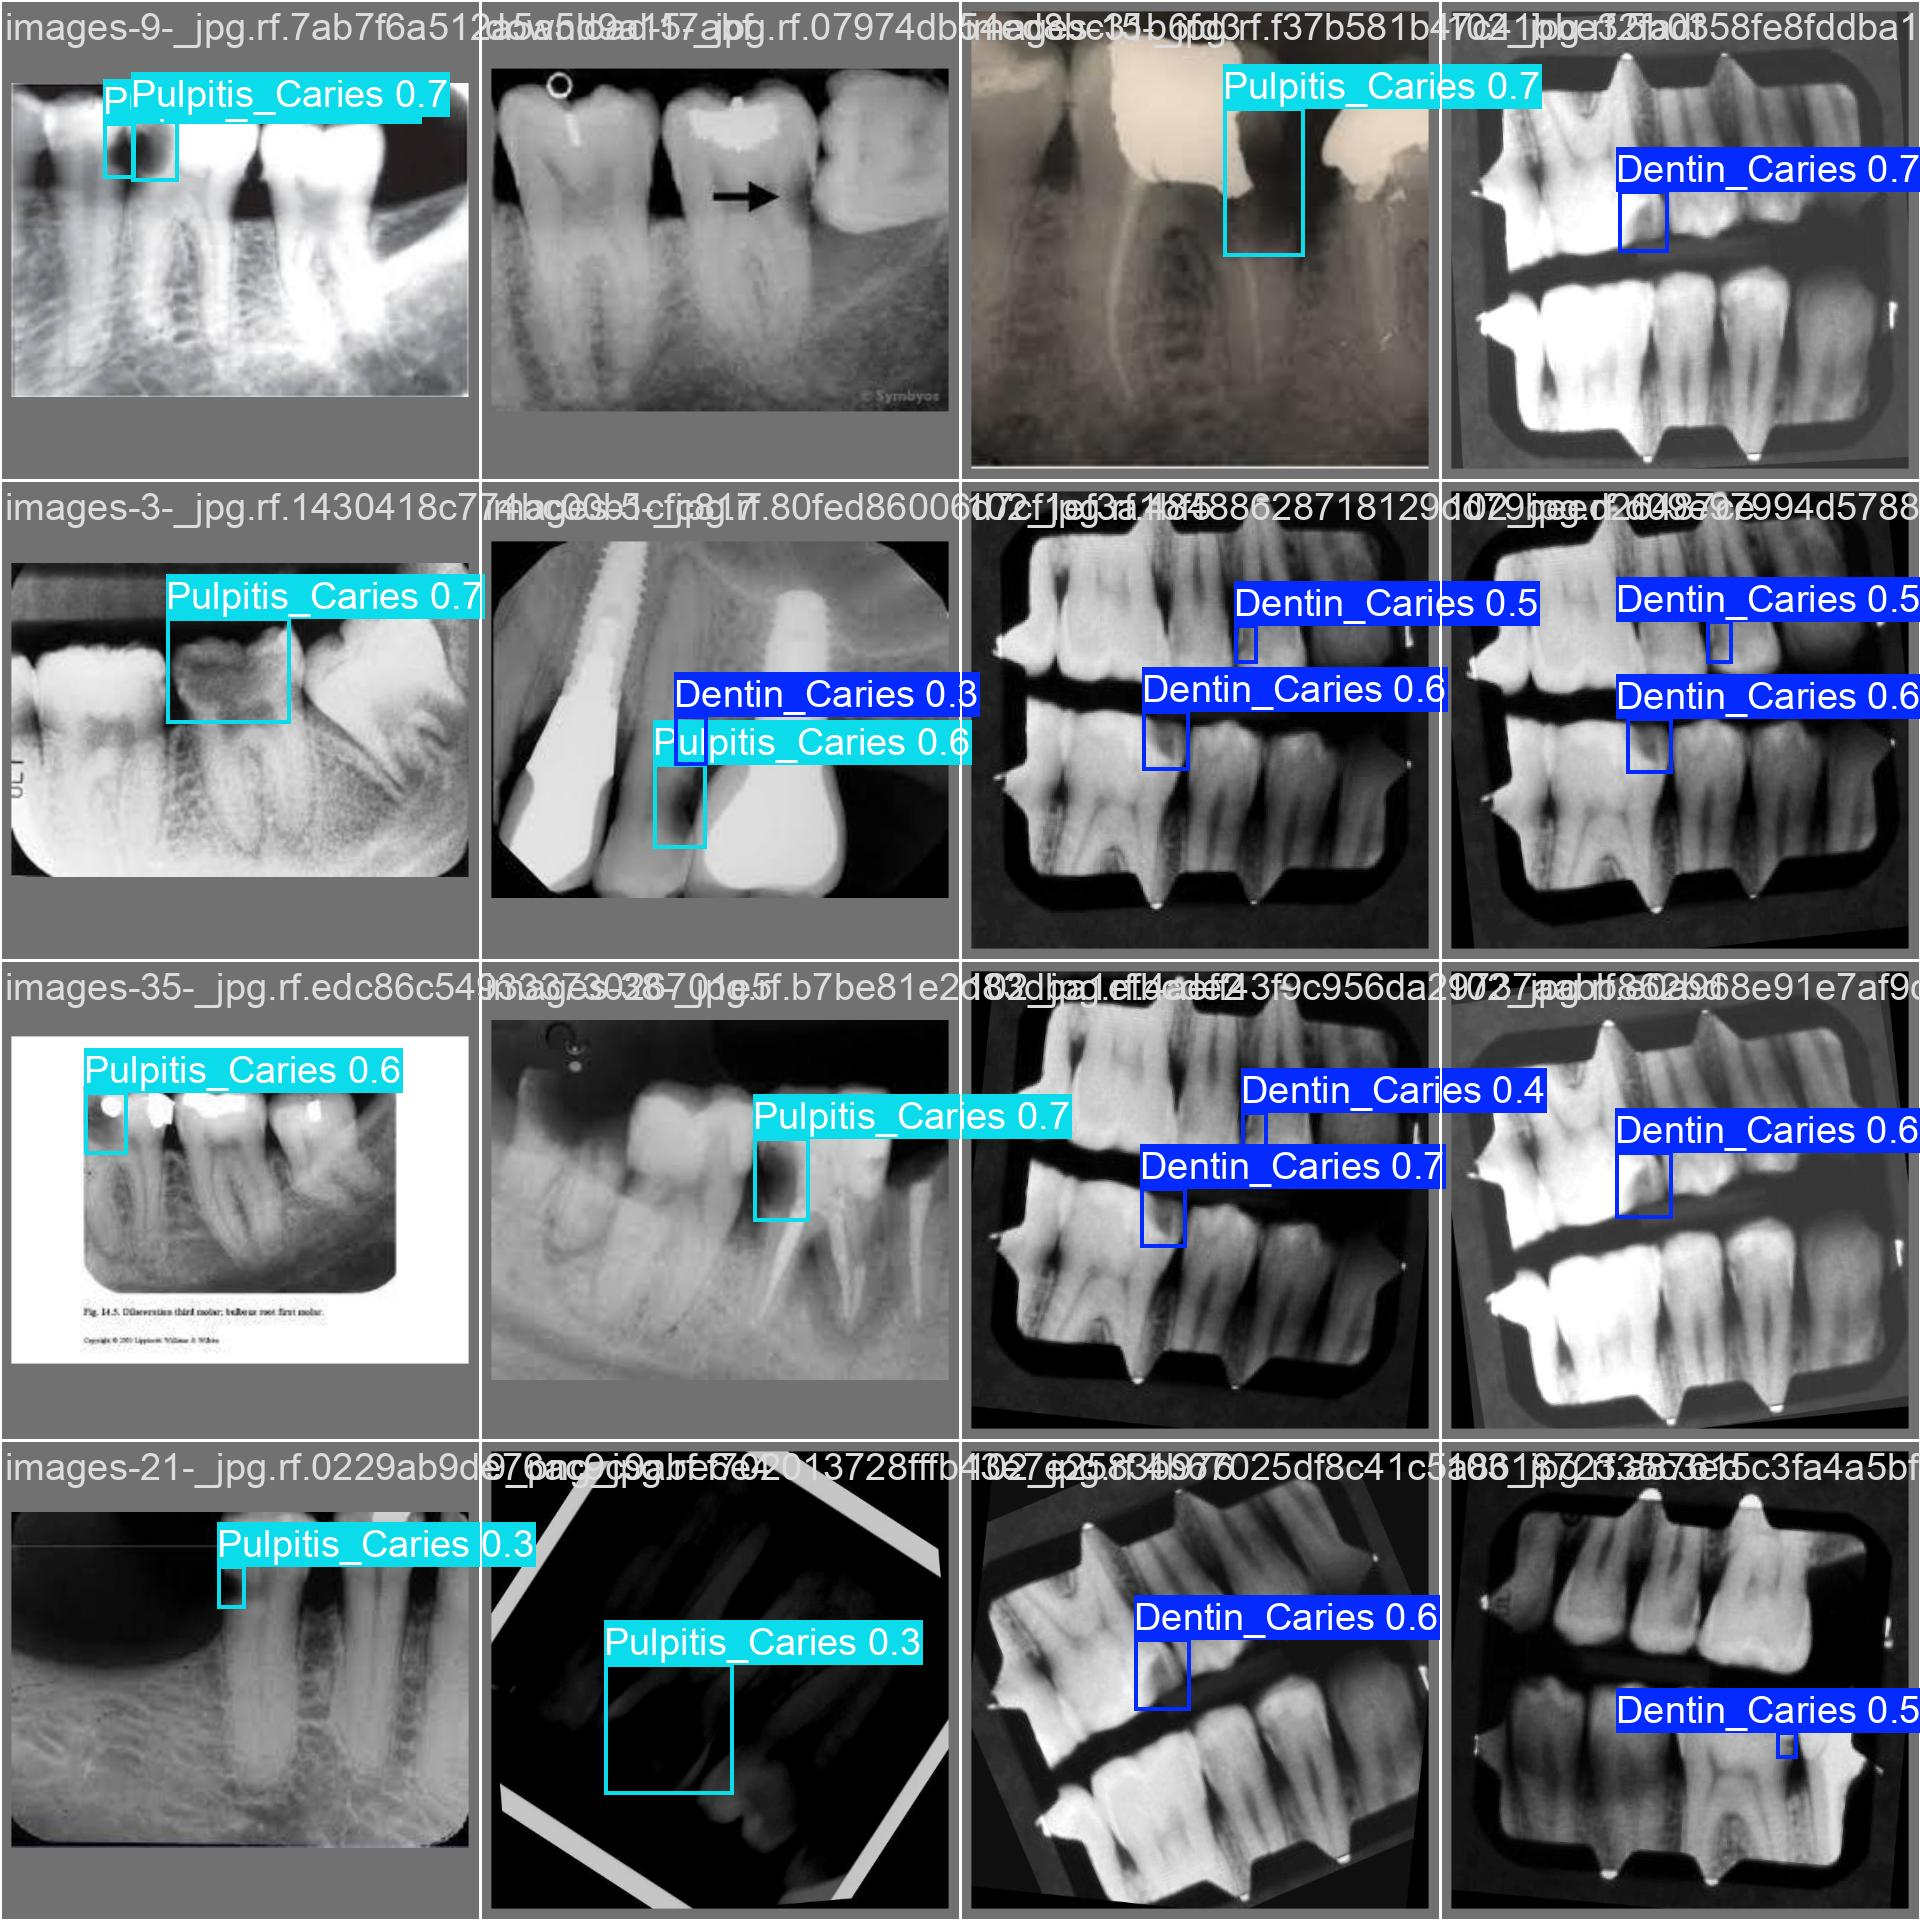

In [22]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/val_batch0_pred.jpg', width=1000)

In [23]:
# Run the validation task using YOLO in Kaggle
!yolo task=detect mode=val model=/kaggle/working/runs/detect/caries_v1_aug/weights/best.pt data=/kaggle/working/yolov11/data/caries_v1/data.yaml

Ultralytics 8.3.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /kaggle/working/yolov11/data/caries_v1/valid/labels... 169 images,
val: New cache created: /kaggle/working/yolov11/data/caries_v1/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        169        266      0.798      0.771      0.804      0.402
         Dentin_Caries         54         85      0.745      0.653      0.699      0.312
       Pulpitis_Caries        141        181      0.852       0.89      0.909      0.492
Speed: 1.9ms preprocess, 5.9ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [24]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 115 (delta 13), reused 8 (delta 8), pack-reused 94 (from 1)
Receiving objects: 100% (115/115), 41.00 MiB | 40.45 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [30]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [31]:
!ls

LICENSE.txt  YOLO_v11_EigenCAM.ipynb  images  yolo_cam
README.md    YOLO_v8n_EigenCAM.ipynb  models


In [32]:
%cd /kaggle/working/YOLO-V8-CAM

/kaggle/working/YOLO-V8-CAM


In [33]:
!pip install ttach

In [34]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [36]:
img = cv2.imread('/kaggle/input/toothdecaydetection/valid/images/14_jpg.rf.546402b30cb494031141695f80a80e3f.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [37]:
model.cpu()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [38]:
target_layers =[model.model.model[-19]]

In [39]:
cam = EigenCAM(model, target_layers,task='od')


0: 640x640 1 Dentin_Caries, 1 Pulpitis_Caries, 151.6ms
Speed: 6.7ms preprocess, 151.6ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)


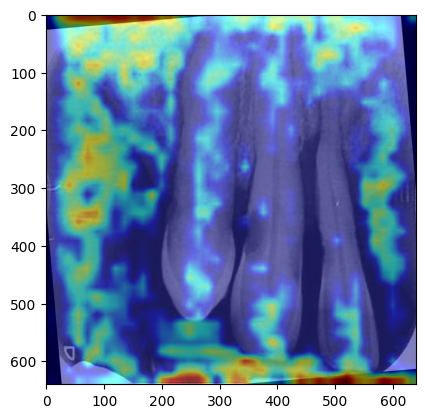

In [40]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [42]:
target_layers =[model.model.model[-18]]


0: 640x640 1 Dentin_Caries, 1 Pulpitis_Caries, 119.3ms
Speed: 4.0ms preprocess, 119.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


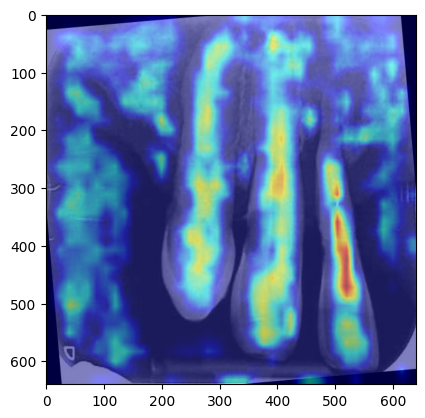

In [43]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [44]:
target_layers =[model.model.model[-15],model.model.model[-16], model.model.model[-17],model.model.model[-18]]



0: 640x640 1 Dentin_Caries, 1 Pulpitis_Caries, 121.7ms
Speed: 2.9ms preprocess, 121.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


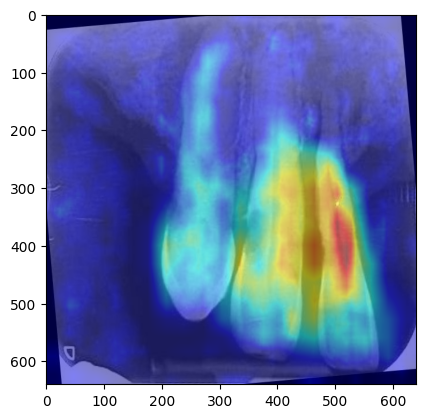

In [45]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

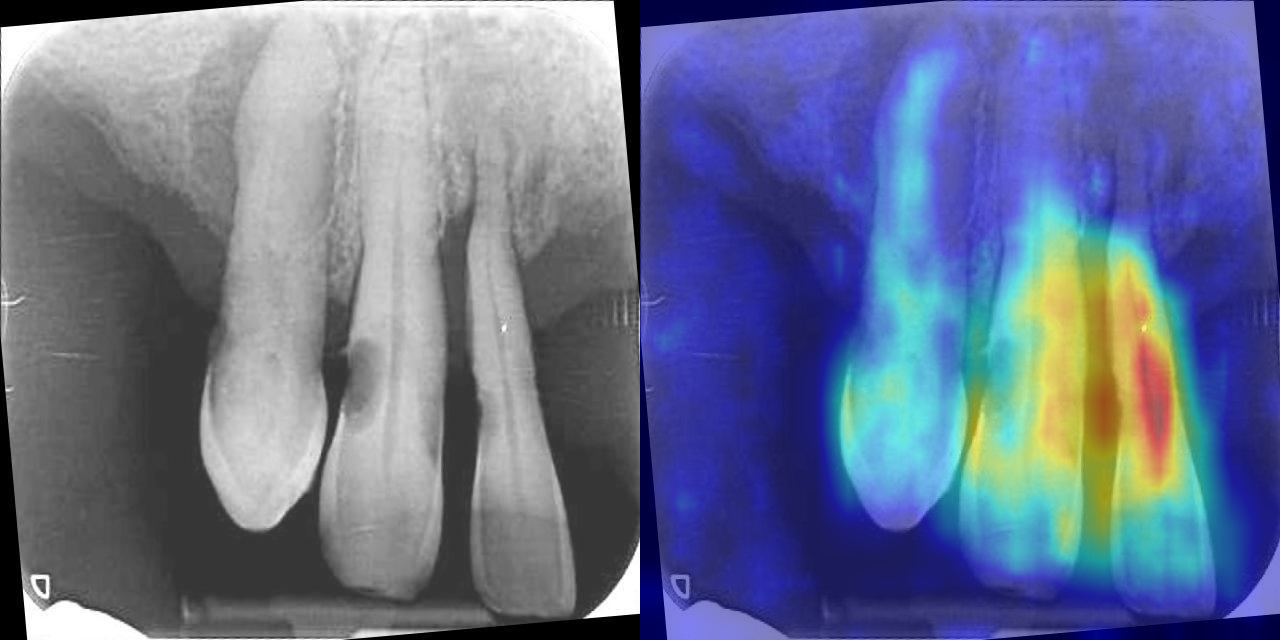

In [46]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

In [47]:
list_of_metrics = ["R_curve.png", "confusion_matrix.png", "results.png"]

In [50]:
%cd /kaggle/working/

/kaggle/working


In [51]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


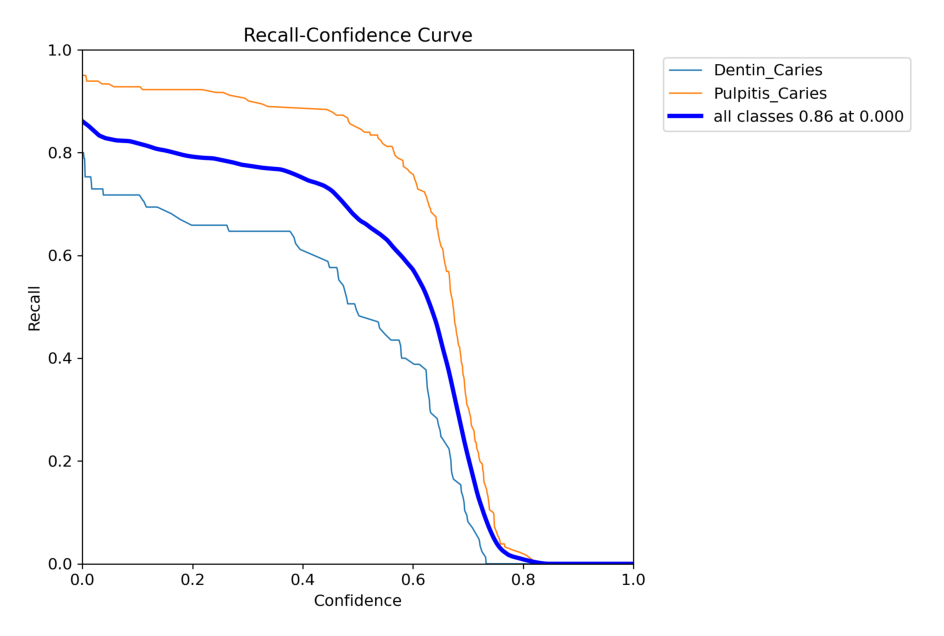

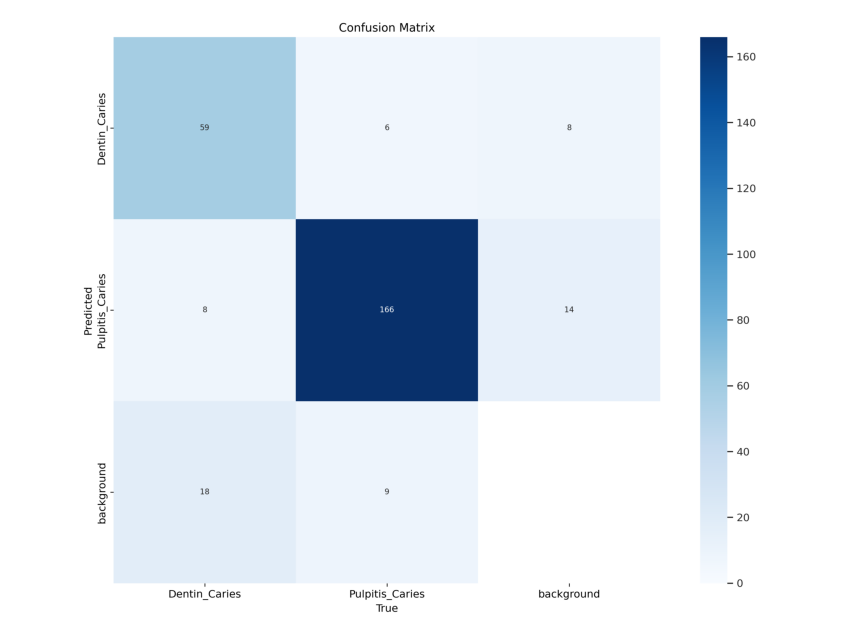

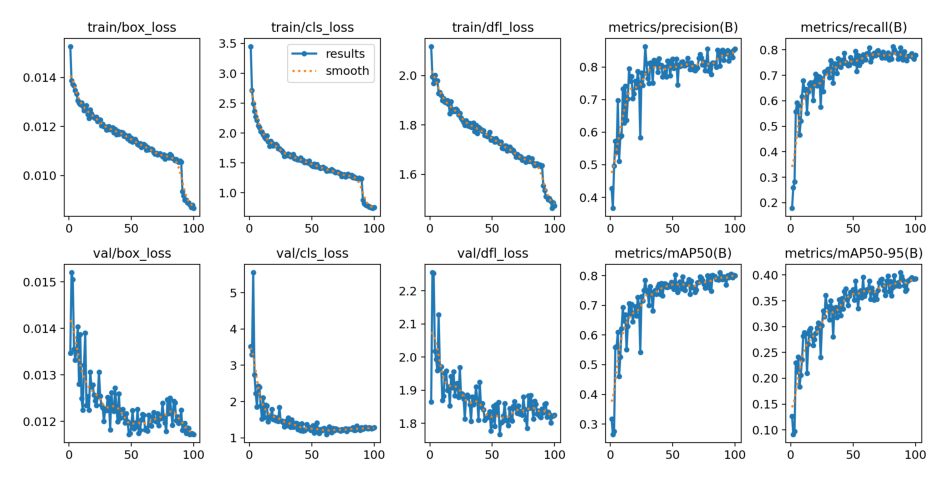

In [55]:
from PIL import Image
for i in list_of_metrics:

    image = Image.open(f'{HOME}/runs/detect/caries_v1_aug/{i}')

    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()
